# Lyric Mood Classification - Mood Classification

In the [word_embeddings](word_embeddings.ipynb) notebook, we demonstrated our embeddings model based on word2vec. In this notebook, we use those embeddings to produce real classification results with a neural network.

First, we split our labeled data into the classic train-dev-test split.

Second, we establish a baseline classification with simple classifiers.

Third, we demonstrate our neural network architecture and model for mood classification.

In [31]:
# Project Imports
from index_lyrics import read_file_contents
from label_lyrics import CSV_LABELED_LYRICS
from scrape_lyrics import LYRICS_TXT_DIR
from lyrics2vec import lyrics2vec

# Python and Package Imports
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import lyrics2vec
import datetime
import json
import time
import csv
import os

%matplotlib inline

## Dataset

The dataset consists of a large number of text files where each file represents a different song. The songs are indexed by a csv file produced by `label_lyrics.py`. We can use the index to retrieve a song's lyrics and observe its matched mood.

We drop all songs that are not english, do not have lyrics available, and do not have a matched mood as classifying across languages is out of scope of this project and no classification can be done on a song without lyrics or without a matched mood.

In [2]:
# we leave out the musixmatch id, artist, and title cols
df = pd.read_csv('data/labeled_lyrics_expanded.csv', usecols=['msd_id', 'msd_artist', 'msd_title', 'is_english', 'lyrics_available', 'wordcount', 'lyrics_filename', 'mood', 'found_tags', 'matched_mood'])
df.columns

/home/jcworkma/jack/w266-group-project_lyric-mood-classification/.venv_w266_project/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['found_tags', 'is_english', 'lyrics_available', 'lyrics_filename',
       'matched_mood', 'mood', 'msd_artist', 'msd_id', 'msd_title',
       'wordcount'],
      dtype='object')

In [3]:
print('Df shape:', df.shape)
df.describe()

Df shape: (779056, 10)


,found_tags,is_english,lyrics_available,matched_mood,wordcount
count,779056.000000,779056.000000,779056.000000,779056.000000,779056.000000
mean,5.870052,0.342566,0.420039,-0.575658,87.716389
std,19.502538,0.474571,0.493565,0.638805,141.151970
min,-1.000000,-1.000000,0.000000,-1.000000,-1.000000
25%,-1.000000,0.000000,0.000000,-1.000000,0.000000
50%,-1.000000,0.000000,0.000000,-1.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,161.000000
max,100.000000,1.000000,1.000000,1.000000,8623.000000


In [4]:
df = df[df.is_english == 1]
print('After is_english filter:', df.shape)
df = df[df.lyrics_available == 1]
print('After lyrics_available filter:', df.shape)
df = df[df.matched_mood == 1]
print('After matched_mood filter:', df.shape)

After is_english filter: (266879, 10)
After lyrics_available filter: (266783, 10)
After matched_mood filter: (63803, 10)


In [5]:
# remove no longer needed columns to conserve memory
df = df.drop(['is_english', 'lyrics_available', 'matched_mood'], axis=1)

In [6]:
# create a categorical data column for moods
# thank you: https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers
df.mood = pd.Categorical(df.mood)
df['mood_cats'] = df.mood.cat.codes
print(df['mood_cats'].unique())
print(df.shape)

[ 4  7 15  2  5 17 16 11  1  0 13 12  9  8  3  6 10 14]
(63803, 8)


In [7]:
# read in the lyrics of each song
def extract_lyrics(lyrics_filepath):
    lyrics = ''
    if os.path.exists(lyrics_filepath):
        lyrics = read_file_contents(lyrics_filepath)[0]
    return lyrics

def make_lyrics_txt_path(lyrics_filename):
    return os.path.join(LYRICS_TXT_DIR, lyrics_filename) + '.txt'

# here we make use of panda's apply function to parallelize the IO operation
df['lyrics'] = df.lyrics_filename.apply(lambda x: extract_lyrics(make_lyrics_txt_path(x)))
df.lyrics.head()

3     And Oceans\nMiscellaneous\nNew Model World\n[i...
7     Electro eroticism\nIntelligence is sexy\nElect...
17    You fight just for the sake of it\nYou know wh...
19    I'm in the dark, I'd like to read his mind\nBu...
25    There was a time\nYou opened up every doorway\...
Name: lyrics, dtype: object

The final number of songs with a matched mood: 63803


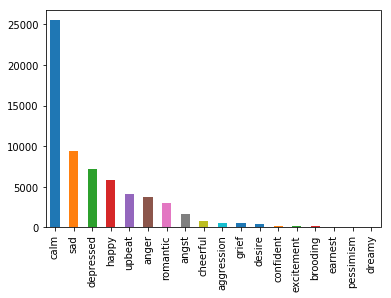

In [8]:
print('The final number of songs with a matched mood:', df.shape[0])
_ = df.mood.value_counts().plot(kind='bar')

In [9]:
df.mood.value_counts()

calm          25502
sad            9397
depressed      7242
happy          5828
upbeat         4124
anger          3723
romantic       3051
angst          1694
cheerful        832
aggression      580
grief           560
desire          397
confident       219
excitement      210
brooding        187
earnest         107
pessimism        90
dreamy           60
Name: mood, dtype: int64

## Train, Dev, & Test

With our dataset index in hand, we are prepared to split the data.

In [10]:
# thank you: https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test/38251213#38251213
# optional random dataframe shuffle
#df = df.reindex(np.random.permutation(df.index))
np.random.seed(12)
def split_data(data):
    return np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

df_train, df_dev, df_test = split_data(df)

In [11]:
print('Train:', df_train.shape)
print('Dev:', df_dev.shape)
print('Test:', df_test.shape)

Train: (38281, 9)
Dev: (12761, 9)
Test: (12761, 9)


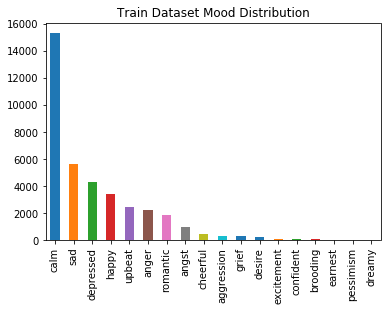

In [12]:
# thank you: https://stackoverflow.com/questions/14992644/turn-pandas-dataframe-of-strings-into-histogram
_ = df_train.mood.value_counts().plot(kind='bar', title='Train Dataset Mood Distribution')

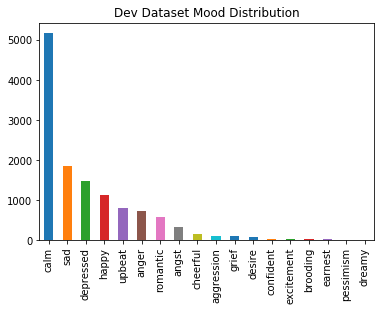

In [13]:
_ = df_dev.mood.value_counts().plot(kind='bar', title='Dev Dataset Mood Distribution')

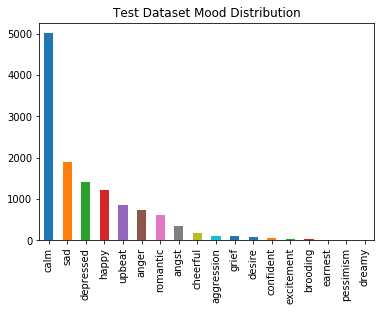

In [14]:
_ = df_test.mood.value_counts().plot(kind='bar', title='Test Dataset Mood Distribution')

## Baselines

### Most-Common-Case Classification

In [15]:
def pprint_accuracy(acc):
    return '{0:.02f}%'.format(acc * 100)

def most_common_case_classification(x, y):
    assert len(x) == len(y)
    total_count = len(x)
    common_count = y.value_counts().max()
    accuracy = common_count / total_count
    return accuracy

In [16]:
print('The most common case for each dataset split is')
print('\tTrain:', df_train.mood.value_counts().idxmax())
print('\tDev:', df_dev.mood.value_counts().idxmax())
print('\tTest:', df_test.mood.value_counts().idxmax())
#df_test.loc[df_test.mood_classes.idxmax()].mood
print('The accuracy of the most-common-case classifier for each dataset split is')
print('\tTrain:', pprint_accuracy(most_common_case_classification(df_train.lyrics_filename, df_train.mood)))
print('\tDev:', pprint_accuracy(most_common_case_classification(df_dev.lyrics_filename, df_dev.mood)))
print('\tTest:', pprint_accuracy(most_common_case_classification(df_test.lyrics_filename, df_test.mood)))


The most common case for each dataset split is
	Train: calm
	Dev: calm
	Test: calm
The accuracy of the most-common-case classifier for each dataset split is
	Train: 40.02%
	Dev: 40.54%
	Test: 39.24%


### Naive-Bayes Classification

The Naive-Bayes Classifier will require the actual lyrical text for classification, so we begin by reading into memory the text for each song in our dataset.

Once we have the lyrics, we use the python sklearn package to vectorize and process the lyrical text, fit the Naive Bayes Classifier, and compute the accuracy.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

def prep_lyrics_for_nb(lyrics_series, count_vect=None, tfidf_transformer=None):
   # thank you: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
    if not count_vect:
        count_vect = CountVectorizer()
        count_vect = count_vect.fit(lyrics_series)
    x_train_counts = count_vect.transform(lyrics_series)
    if not tfidf_transformer:
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(x_train_counts)
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
    return count_vect, x_train_counts, tfidf_transformer, x_train_tfidf

# convert lyrics to counts and term-frequencies
count_vect, x_train_counts, tfidf_transformer, x_train_tfidf = prep_lyrics_for_nb(df_train.lyrics)
print(x_train_tfidf.shape)
_, x_dev_counts, _, x_dev_tfidf = prep_lyrics_for_nb(df_dev.lyrics, count_vect, tfidf_transformer)
print(x_dev_tfidf.shape)
_, x_test_counts, _, x_test_tfidf = prep_lyrics_for_nb(df_test.lyrics, count_vect, tfidf_transformer)
print(x_test_tfidf.shape)

(38281, 62247)
(12761, 62247)
(12761, 62247)


In [20]:
clf = MultinomialNB().fit(x_train_tfidf, df_train.mood_cats) 
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('Naive Bayes Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('Naive Bayes Classifier Test Accuracy:', pprint_accuracy(test_acc))

Naive Bayes Classifier Dev Accuracy: 40.76%
Naive Bayes Classifier Test Accuracy: 39.39%


### SVM Classification

From [Corona & O'Mahony](https://www.researchgate.net/publication/280733696_An_Exploration_of_Mood_Classification_in_the_Million_Songs_Dataset), SVMs have been used with success in this area. Here we see that they do provide a sizeable increase in accuracy over NB.

In [21]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42,
            max_iter=5, tol=None).fit(x_train_tfidf, df_train.mood_cats)
dev_acc = clf.score(x_dev_tfidf, df_dev.mood_cats)
print('SVM Classifier Dev Accuracy:', pprint_accuracy(dev_acc))
test_acc = clf.score(x_test_tfidf, df_test.mood_cats)
print('SVM Classifier Test Accuracy:', pprint_accuracy(test_acc))

SVM Classifier Dev Accuracy: 45.40%
SVM Classifier Test Accuracy: 44.39%


## Neural Networks

### CNN

http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/

CNNs process textual input different than a Naive Bayes or SVM classifier. We perform the following data processing steps on all lyrics:
* Truncate/extend all songs to the 75% wordcount percentile
* Tokenize lyrics with nltk's word_tokenize function
* Remove all stopwords that match from within nltk's stopwords corpus
* Remove punctuation

In [22]:
pctiles = df.wordcount.describe()
print(pctiles)
cutoff = int(pctiles[pctiles.index.str.startswith('75%')][0])
print('\nAll songs will be limited to {0} words'.format(cutoff))

count    63803.000000
mean       231.658982
std        139.035896
min          1.000000
25%        143.000000
50%        204.000000
75%        282.000000
max       2913.000000
Name: wordcount, dtype: float64

All songs will be limited to 282 words


In [23]:
from importlib import reload
reload(lyrics2vec)
lyrics_vectorizer = lyrics2vec.lyrics2vec.InitFromLyrics()

In [24]:
def normalize_lyrics(lyrics, max_length, lyrics_vectorizer):
    """
    Tokenize, process, shorten/lengthen, and vectorize lyrics
    """
    lyrics = lyrics2vec.lyrics_preprocessing(lyrics)
    if len(lyrics) > max_length:
        lyrics = lyrics[:max_length]
    else:
        lyrics += ['<PAD>'] * (int(max_length) - int(len(lyrics)))

    lyric_vector = lyrics_vectorizer.transform(lyrics)
    return lyric_vector

start = time.time()

# here we make use of panda's apply function to parallelize the IO operation (again)
df_train['normalized_lyrics'] = df_train.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('train data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_train.normalized_lyrics.head())

df_dev['normalized_lyrics'] = df_dev.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('dev data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_dev.normalized_lyrics.head())

df_test['normalized_lyrics'] = df_test.lyrics.apply(lambda x: normalize_lyrics(x, cutoff, lyrics_vectorizer))
print('test data normalized ({0} minutes)'.format((time.time() - start) / 60))
print(df_test.normalized_lyrics.head())

print('\nExample of padding:')
example = df_train.normalized_lyrics[df_train.normalized_lyrics.str.len() == cutoff].iloc[0]
print('\tFirst 5 tokens: {0}'.format(example[:5]))
print('\tLast 5 tokens: {0}.'.format(example[-5:]))

print('\nElapsed Time: {0} minutes'.format((time.time() - start) / 60))

train data normalized (0.8257552981376648 minutes)
228247    [526, 43, 99, 5, 15, 77, 234, 179, 19, 86, 383...
214654    [37, 93, 868, 3364, 2, 12, 596, 1668, 873, 4, ...
175139    [71, 44, 297, 250, 2271, 1511, 127, 1310, 231,...
58579     [37, 93, 1, 100, 382, 122, 181, 38, 162, 35, 1...
196716    [253, 7, 43, 22, 1, 209, 209, 3, 147, 7, 94, 7...
Name: normalized_lyrics, dtype: object
dev data normalized (1.0960610191027322 minutes)
149604    [315, 26, 8, 95, 280, 7, 136, 201, 5, 37330, 4...
71942     [37, 93, 24, 68, 1462, 12, 213, 6044, 43, 231,...
91524     [37, 93, 269, 14574, 130, 1032, 1107, 6, 1467,...
238415    [37, 93, 60, 245, 800, 2179, 0, 288, 250, 0, 1...
162087    [37, 143, 1495, 143, 146, 48086, 14761, 391, 4...
Name: normalized_lyrics, dtype: object
test data normalized (1.3717837452888488 minutes)
248608    [24, 26, 12, 766, 7, 222, 6, 45, 2295, 1402, 2...
240285    [99, 212, 99, 99, 315, 124, 1840, 194, 235, 33...
200631    [15, 294, 3904, 656, 193, 1133, 193, 4136,

# **Following code is borrowed from [this excellent and very helpful blog post](http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/) to PoC the validity of the preprocessed tokens and word embeddings**


And here's a walkthrough of that blog post's code: https://agarnitin86.github.io/blog/2016/12/23/text-classification-cnn

In [25]:
class TextCNN(object):
    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """
    def __init__(
      self, sequence_length, num_classes, vocab_size,
      embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0,
      embeddings=None):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        # for loading word2vec: https://stackoverflow.com/questions/35687678/using-a-pre-trained-word-embedding-word2vec-or-glove-in-tensorflow
        with tf.device('/cpu:0'), tf.name_scope("embedding"):

            self.pretrained_embeddings = embeddings is not None
            if self.pretrained_embeddings:
                self.W = tf.get_variable(
                    shape=embeddings.shape,
                    initializer=tf.constant_initializer(embeddings),
                    trainable=True,
                    name="W")
            else:
                self.W = tf.Variable(
                    tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0),
                    name="W")
            
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                Wconv = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="Wconv")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    Wconv,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            Wconv = tf.get_variable(
                "Wconv",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(Wconv)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, Wconv, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")

        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")

In [29]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """
    Generates a batch iterator for a dataset.
    """
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print('num_batches_per_epoch = {0}'.format(num_batches_per_epoch))
    for epoch in range(num_epochs):
        print('***********************************************')
        print('Epoch {0}/{1}\n'.format(epoch, num_epochs))
        # Shuffle the data at each epoch
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            print('-----------------------------------------------')
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            print('Epoch {0}/{1}, Batch {2}/{3} (start={4}, end={5})'.format(
                epoch, num_epochs, batch_num, num_batches_per_epoch, start_index, end_index))
            yield shuffled_data[start_index:end_index]
            
def train(vocab_size, x_train, y_train, x_dev, y_dev, x_test, y_test, train_embeddings=False, embeddings=None):
    # Training
    # ==================================================

    with tf.Graph().as_default():
        session_conf = tf.ConfigProto()
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                #vocab_size=len(vocab_processor.vocabulary_),
                vocab_size=vocab_size,
                embedding_size=embedding_dim,
                filter_sizes=filter_sizes,
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda,
                embeddings=embeddings)

            # Define Training procedure
            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(1e-3)
            grads_and_vars = optimizer.compute_gradients(cnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

            # Keep track of gradient values and sparsity (optional)
            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)

            # Output directory for models and summaries
            if USE_TIME_AS_KEY:
                experiment_name = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
            else:
                experiment_name = make_experiment_name()'Em-{0}_FS-{1}_NF-{2}_D-{3}_L2-{4}_B-{5}_Ep-{6}_W2V-{7}{8}_V-{9}'.format(
                    embedding_dim, '-'.join(map(str, filter_sizes)),
                    num_filters,
                    dropout_keep_prob,
                    l2_reg_lambda,
                    batch_size,
                    num_epochs,
                    1 if cnn.pretrained_embeddings else 0,
                    '-Tr' if train_embeddings else '',
                    vocab_size)
            out_dir = os.path.abspath(os.path.join(lyrics2vec.LOGS_TF_DIR, "runs", experiment_name))
            os.makedirs(out_dir)
            print("Writing to {}\n".format(out_dir))
            
            # dump params to json in case they need to be referenced later
            with open(os.path.join(out_dir, 'model_params.json'), 'w') as outfile:
                model_params = {
                    'embedding_dim': embedding_dim,
                    'filter_sizes': filter_sizes,
                    'num_filters': num_filters,
                    'dropout_keep_prob': dropout_keep_prob,
                    'l2_reg_lambda': l2_reg_lambda,
                    'batch_size': batch_size,
                    'num_epochs': num_epochs,
                    'evaluate_every': evaluate_every,
                    'checkpoint_every': checkpoint_every,
                    'num_checkpoints': num_checkpoints,
                    'train_embeddings': train_embeddings,
                    'pretrained_embeddings': cnn.pretrained_embeddings
                }
                json.dump(model_params, outfile, sort_keys=True)
                
            # Summaries for loss and accuracy
            loss_summary = tf.summary.scalar("loss", cnn.loss)
            acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

            # Train Summaries
            summary_dir = os.path.join(out_dir, "summaries")
            train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
            train_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "train"), sess.graph)

            # Dev summaries
            dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
            dev_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "dev"), sess.graph)

            # Test summaries
            test_summary_op = tf.summary.merge([loss_summary, acc_summary])
            test_summary_writer = tf.summary.FileWriter(os.path.join(summary_dir, "test"), sess.graph)
            
            # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

            # Write vocabulary
            #vocab_processor.save(os.path.join(out_dir, "vocab"))

            # Initialize all variables
            sess.run(tf.global_variables_initializer())

            def train_step(x_batch, y_batch, summary_writer=None, step_writer=None):
                """
                A single training step
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if summary_writer:
                    summary_writer.add_summary(summaries, step)
                if step_writer:
                    step_writer.writerow(['train', time_str, step, loss, accuracy])
                return time_str, step, loss, accuracy

            def dev_step(x_batch, y_batch, summary_writer=None, step_writer=None):
                """
                Evaluates model on a dev set
                """
                feed_dict = {
                  cnn.input_x: x_batch,
                  cnn.input_y: y_batch,
                  cnn.dropout_keep_prob: 1.0
                }
                step, summaries, loss, accuracy = sess.run(
                    [global_step, dev_summary_op, cnn.loss, cnn.accuracy],
                    feed_dict)
                time_str = datetime.datetime.now().isoformat()
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
                if summary_writer:
                    summary_writer.add_summary(summaries, step)
                if step_writer:
                    step_writer.writerow(['train', time_str, step, loss, accuracy])
                return time_str, step, loss, accuracy
                   
            csvwriter = None
            if SAVE_STEP_DATA:
                csvfile = open(os.path.join(out_dir, 'step_data.csv'), 'w')
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['dataset', 'time', 'step', 'loss', 'acc'])
                
            # Generate batches
            batches = batch_iter(
                list(zip(x_train, y_train)), batch_size, num_epochs)
            # Training loop. For each batch...
            for batch in batches:
                x_batch, y_batch = zip(*batch)
                train_step(x_batch, y_batch, summary_writer=train_summary_writer, step_writer=csvwriter)
                current_step = tf.train.global_step(sess, global_step)
                if current_step % evaluate_every == 0:
                    print("\nEvaluation:")
                    dev_step(x_dev, y_dev, summary_writer=dev_summary_writer, step_writer=csvwriter)
                    print("")
                if current_step % checkpoint_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                    print("Saved model checkpoint to {}\n".format(path))
                    
            print("\nFinal Test Evaluation:")
            dev_step(x_test, y_test, summary_writer=test_summary_writer, step_writer=csvwriter)


In [30]:
# get our pre-trained word2vec embeddings
lyrics_vectorizer = lyrics2vec.lyrics2vec()
embeddings_loaded = lyrics_vectorizer.load_embeddings()
if embeddings_loaded:
    print('embeddings shape:', lyrics_vectorizer.final_embeddings.shape)
else:
    print('failed to load embeddings!')

embeddings shape: (50000, 300)


In [ ]:
# Parameters
# ==================================================

SAVE_STEP_DATA = True
USE_TIME_AS_KEY = False

# Model Hyperparameters
embedding_dim = 300
filter_sizes = [3,4,5]
num_filters = 4
dropout_keep_prob = 0.5
l2_reg_lambda = 0.01

# Training parameters
batch_size = 128
num_epochs = 10
evaluate_every = 100
checkpoint_every = 100
num_checkpoints = 5

# tensorboard vars
experiment_name = None


def make_experiment_name(embedding_dim, filter_sizes, num_filters, dropout_keep_prob, l2_reg_lamda,
                         batch_size, num_epochs, pretrained_embeddings, train_embeddings, vocab_size)
    experiment_name = 'Em-{0}_FS-{1}_NF-{2}_D-{3}_L2-{4}_B-{5}_Ep-{6}_W2V-{7}{8}_V-{9}'.format(
        embedding_dim,
        '-'.join(map(str, filter_sizes)),
        num_filters,
        dropout_keep_prob,
        l2_reg_lambda,
        batch_size,
        num_epochs,
        1 if cnn.pretrained_embeddings else 0,
        '-Tr' if train_embeddings else '',
        vocab_size)
    return experiment_name

In [28]:
def build_tensorboard_logdir(runs):
    """
    Constructs a tensorboard command out of <runs>
    Ex: !tensorboard --logdir 
        w2v0:logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-64_Ep-20/summaries/,
        w2v0-moodexp:logs/tf/runs/Em-300_FS-3-4-5_NF-64_D-0.5_L2-0.01_B-64_Ep-20_W2V-0-Tr_V-50000/summaries/
        
    Args:
        runs: list of tuples, each tuple is a run with (<name>, <path>)
        
    Returns: str, tensorboard logdir
    """
    logdir = ''
    for run in runs:
        if len(run) != 2:
            raise Exception('improperly formatted run: {0}'.format(runs))
        name = run[0]
        path = run[1]
        logdir += '{0}:{1},'.format(name, path)
    # remove final comma
    logdir = logdir[:-1]
    return logdir

best = ('w2v0', 'logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-64_Ep-20/summaries/')
tb_logdir = build_tensorboard_logdir([best, ('new', experiment_name)])
print(tb_logdir)
!tensorboard --logdir {tb_logdir}

w2v0:logs/tf/runs/Em-128_FS-3-4-5_NF-128_D-0.5_L2-0.01_B-64_Ep-20/summaries/,new:None
TensorBoard 1.12.0 at http://workman-ubuntu-desk:6006 (Press CTRL+C to quit)
^C


In [42]:
V = lyrics2vec.VOCAB_SIZE
#V = 50000
# need to convert lyrics into numpy 2d arrays
# need to convert classes into dummies
train_embeddings = False

train(
    vocab_size=V,
    x_train=np.array(list(df_train.normalized_lyrics)),
    y_train=pd.get_dummies(df_train.mood).values,
    x_dev=np.array(list(df_dev.normalized_lyrics)),
    y_dev=pd.get_dummies(df_dev.mood).values,
    x_test=np.array(list(df_test.normalized_lyrics)),
    y_test=pd.get_dummies(df_test.mood).values,
    train_embeddings=train_embeddings,
    embeddings=lyrics_vectorizer.final_embeddings
)

INFO:tensorflow:Summary name W:0/grad/hist is illegal; using W_0/grad/hist instead.
INFO:tensorflow:Summary name W:0/grad/sparsity is illegal; using W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/hist is illegal; using conv-maxpool-3/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/Wconv:0/grad/sparsity is illegal; using conv-maxpool-3/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; using conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/sparsity is illegal; using conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/hist is illegal; using conv-maxpool-4/Wconv_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-4/Wconv:0/grad/sparsity is illegal; using conv-maxpool-4/Wconv_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-4/b:0/grad/hist is illegal; using conv-max

2018-11-27T12:57:36.826798: step 38, loss 2.42974, acc 0.25
-----------------------------------------------
Epoch 0/10, Batch 38/599 (start=2432, end=2496)
2018-11-27T12:57:37.121390: step 39, loss 2.38635, acc 0.28125
-----------------------------------------------
Epoch 0/10, Batch 39/599 (start=2496, end=2560)
2018-11-27T12:57:37.409030: step 40, loss 2.5176, acc 0.21875
-----------------------------------------------
Epoch 0/10, Batch 40/599 (start=2560, end=2624)
2018-11-27T12:57:37.686641: step 41, loss 2.56042, acc 0.25
-----------------------------------------------
Epoch 0/10, Batch 41/599 (start=2624, end=2688)
2018-11-27T12:57:37.979345: step 42, loss 2.36115, acc 0.28125
-----------------------------------------------
Epoch 0/10, Batch 42/599 (start=2688, end=2752)
2018-11-27T12:57:38.280206: step 43, loss 2.59357, acc 0.21875
-----------------------------------------------
Epoch 0/10, Batch 43/599 (start=2752, end=2816)
2018-11-27T12:57:38.565405: step 44, loss 2.57905, ac

2018-11-27T12:57:51.577775: step 90, loss 2.38886, acc 0.234375
-----------------------------------------------
Epoch 0/10, Batch 90/599 (start=5760, end=5824)
2018-11-27T12:57:51.867232: step 91, loss 2.4116, acc 0.265625
-----------------------------------------------
Epoch 0/10, Batch 91/599 (start=5824, end=5888)
2018-11-27T12:57:52.134797: step 92, loss 2.19525, acc 0.40625
-----------------------------------------------
Epoch 0/10, Batch 92/599 (start=5888, end=5952)
2018-11-27T12:57:52.427404: step 93, loss 2.57176, acc 0.21875
-----------------------------------------------
Epoch 0/10, Batch 93/599 (start=5952, end=6016)
2018-11-27T12:57:52.721489: step 94, loss 2.41464, acc 0.28125
-----------------------------------------------
Epoch 0/10, Batch 94/599 (start=6016, end=6080)
2018-11-27T12:57:53.004868: step 95, loss 2.3357, acc 0.296875
-----------------------------------------------
Epoch 0/10, Batch 95/599 (start=6080, end=6144)
2018-11-27T12:57:53.291113: step 96, loss 2.3

2018-11-27T12:58:10.526148: step 140, loss 2.21829, acc 0.375
-----------------------------------------------
Epoch 0/10, Batch 140/599 (start=8960, end=9024)
2018-11-27T12:58:10.813899: step 141, loss 2.25188, acc 0.359375
-----------------------------------------------
Epoch 0/10, Batch 141/599 (start=9024, end=9088)
2018-11-27T12:58:11.101620: step 142, loss 2.40184, acc 0.28125
-----------------------------------------------
Epoch 0/10, Batch 142/599 (start=9088, end=9152)
2018-11-27T12:58:11.390372: step 143, loss 2.36509, acc 0.25
-----------------------------------------------
Epoch 0/10, Batch 143/599 (start=9152, end=9216)
2018-11-27T12:58:11.684046: step 144, loss 2.36475, acc 0.34375
-----------------------------------------------
Epoch 0/10, Batch 144/599 (start=9216, end=9280)
2018-11-27T12:58:11.980495: step 145, loss 2.46542, acc 0.234375
-----------------------------------------------
Epoch 0/10, Batch 145/599 (start=9280, end=9344)
2018-11-27T12:58:12.273956: step 146,

KeyboardInterrupt: 

# Experiments

Reigning Champion: w2v0

batch_size of 32 speeds up training but doesn't impact scalars too much  
L2 has impact - kind of judged that .01 is the best  
Embedding size - 300 > 128 for word2vec; no word2vec 128 still reigns supreme

Open questions:
* vocab size adjustments? currently a lot of nonsense words are in there - would we be more more accurate if we removed those?
* word embeddings - lots of experiments to run there
* dropout rate
* Can we make a full pipeline that trains word embeddings based on params then uses word embedding to train model based on params then analyses results to find best loss+accuracy point and save accuracy? Then we could let 100 experiments go in a day and see what happens
* concatenate word2vec with untrained embeddings
* word2vec trainable

Using expanded dataset with w2v0 and standard settings yielded test acc of ~52. Loss begin climbing at 4.5k steps at which point acc was ~50. Will drop epoch to 10 as steps went to 12k and 6k should be enough to see improvement. Trying again with w2v1.

Three things:

1. Build complete experimental pipeline
2. dethrone chill as king of moods
3. improve word2vec